# Part 2 - Network load evaluation


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from tqdm import tqdm, trange

from package import constants
from package.connectivity import bfs_is_connected
# from networkx import erdos_renyi_graph, random_regular_graph, adjacency_matrix
import networkx as nx

plt.rcParams["figure.figsize"] = (8,4)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette='muted', rc = custom_params)
N = 10000

In [3]:
from collections import Counter

from package.graph_utilities import leaves, n_closest, count_closest, arg_n_smallest, select_nodes

## 2.1

We first define the two networks, also attaching and defining which nodes of the network are servers and which are routers.

### r-Regular Graph:


In [12]:
k = constants.n_ports//2
# create core random routers graph
rrg = nx.random_regular_graph(d = k, n=k**2)
while not bfs_is_connected(rrg):
    rrg = nx.random_regular_graph(d = k, n=k**2)

# add endpoints
for n in list(rrg.nodes()):
    endnodes = range(-n*k-1,-(n+1)*k-1,-1)
    rrg.add_nodes_from(endnodes, server=True)
    rrg.add_edges_from(zip([n]*k,endnodes))
rrg_servers = leaves(rrg)

In [13]:
Counter(n_closest(rrg, 10000, -1,leaves(rrg)).values())

Counter({4: 8945, 3: 1024, 2: 31})

32768

### Fat-Tree graph
we assume that when considering only the number of jumps between two different servers, a fat-tree is equivalent to a tree.

In [15]:
ft = nx.full_rary_tree(r = k, n=sum(k**i for i in range(4)))

# define endpoints
ft_servers = leaves(ft)
ft.add_nodes_from(ft_servers, server=True)

### Check:
The two topologies must have the same number of servers:

In [17]:
len(ft_servers) == len(rrg_servers)

True

### Simulation of Response Time
We can simulate the response time by computing the average throughput, and then sampling from some distributions

In [18]:
def response_time(g: nx.Graph, N: int, src: int, servers : set, targets :dict = None):
    targets = n_closest(g, N, src, servers) if targets is None else targets
    h = np.fromiter(targets.values(), dtype=int) # number of hops
    rtt = 2 * constants.propagation_time * h
    throughput = constants.capacity / rtt / sum(1/rtt)
    
    input_data = constants.input_data_size / N
    
    output_data = np.random.uniform(0, 2*constants.output_data_size / N, N)
    # uniform distribution in [0, 2 * output_size / N]
    
    transferred_data = input_data + output_data + input_data*constants.packet_overhead
    transfer_time = transferred_data / throughput
    
    
    computation_time = constants.setup_time + np.random.exponential(constants.mean_total_compute_time/N, N)
    
    return max(computation_time + transfer_time)

response_time(rrg, 1000, -1, select_nodes(rrg, server=True))

10157.132397743135

### Mean Response time
This is the same thing as above, but this time no sampling is involved and only the mean is taken.


In [19]:
def mean_transfer_time(hops, N):
    hops = count_closest(hops, N) # number of hops
    h = np.fromiter(hops.keys(), int, len(hops))
    rtt = 2 * constants.propagation_time * h
    const = sum(n/r for n,r in zip(hops.values(), rtt))
    throughput = min( constants.capacity / rtt / const )
    input_data = constants.input_data_size / N
    
    output_data = (2* constants.output_data_size / N) * N / (N+1)
    # uniform distribution in [0, 2 * output_size / N]
    
    transferred_data = output_data + input_data*(1 + constants.packet_overhead)
    transfer_time = transferred_data / throughput
    return transfer_time

In [20]:
def mean_response_time(g: nx.Graph, N: int, src: int, targets : set):
    targets = count_closest(targets, N)
    transfer_time = mean_transfer_time(targets, N)
    
    max_comp_time = sum(1/n for n in range(1, N+1))*constants.mean_total_compute_time/N
    computation_time = constants.setup_time + max_comp_time
    
    return computation_time + transfer_time

servers = n_closest(rrg, 10000, -1,leaves(rrg))
server_count = Counter(servers.values())
mean_response_time(rrg, 1000, -1, server_count)

10328.187121316116

## 2.2 Simulation

In [21]:
N = 10000

def simulation(g, N):
    sn = select_nodes(g, server=True)
    
    src= next(iter(sn))
    servers = Counter(n_closest(g, N, src, sn).values())
    
    trials = pd.DataFrame(dict(
        N = list(range(1, N+1)),
    ))

    tqdm.pandas(desc='Response Simulation')
    trials['R'] = trials.N.progress_map(
        lambda n: mean_response_time(g, n, src, servers)
    )
    return trials


In [22]:
trials = pd.concat([
    simulation(ft,  N),
    simulation(rrg, N)
], 
    keys=['Fat-Tree','Jellyfish'],
    names=['kind', 'id']
)
trials = trials.reset_index(level='kind').reset_index(drop=True)
trials

Response Simulation: 100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2328.82it/s]


,kind,N,R
0,Fat-Tree,1,35488.457600
1,Fat-Tree,2,29380.724267
2,Fat-Tree,3,25926.857600
3,Fat-Tree,4,23654.537600
4,Fat-Tree,5,22024.990933
...,...,...,...
19995,Jellyfish,9996,10362.846844
19996,Jellyfish,9997,10362.807364
19997,Jellyfish,9998,10362.767891
19998,Jellyfish,9999,10362.728427


In [23]:
R_baseline = constants.setup_time + constants.mean_total_compute_time
trials['R_scaled'] = trials.R / R_baseline

### Response Plot:

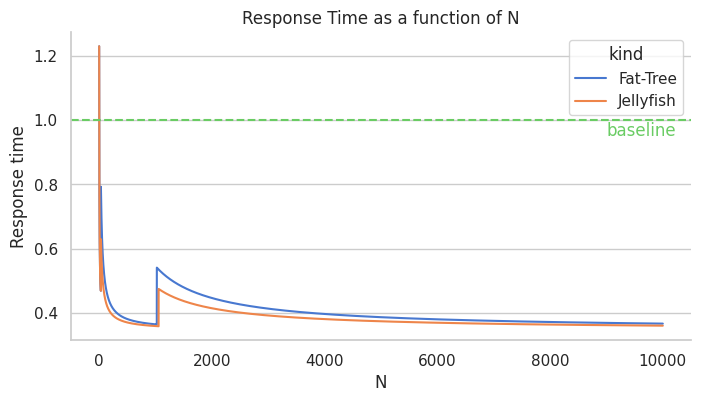

In [24]:
# sns.set_style('darkgrid')
baseline_color = sns.color_palette('muted')[2]
ax = sns.lineplot(
    trials, 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (9000, .95), color = baseline_color)
plt.gca().xaxis.grid(False)

## 2.3 Job Cost

In [25]:
# E[Theta]
mean_server_time = lambda N: N *constants.setup_time + constants.mean_total_compute_time

trials['Theta'] = trials.N.map(mean_server_time)
trials['S'] = trials.R + constants.xi * trials.Theta

S_baseline = R_baseline + constants.xi * mean_server_time(1)
trials['S_scaled'] = trials.S / S_baseline

trials

,kind,N,R,R_scaled,Theta,S,S_scaled
0,Fat-Tree,1,35488.457600,1.230956,28830,38371.457600,1.209960
1,Fat-Tree,2,29380.724267,1.019102,28860,32266.724267,1.017460
2,Fat-Tree,3,25926.857600,0.899301,28890,28815.857600,0.908645
3,Fat-Tree,4,23654.537600,0.820483,28920,26546.537600,0.837087
4,Fat-Tree,5,22024.990933,0.763961,28950,24919.990933,0.785797
...,...,...,...,...,...,...,...
19995,Jellyfish,9996,10362.846844,0.359447,328680,43230.846844,1.363190
19996,Jellyfish,9997,10362.807364,0.359445,328710,43233.807364,1.363283
19997,Jellyfish,9998,10362.767891,0.359444,328740,43236.767891,1.363377
19998,Jellyfish,9999,10362.728427,0.359443,328770,43239.728427,1.363470


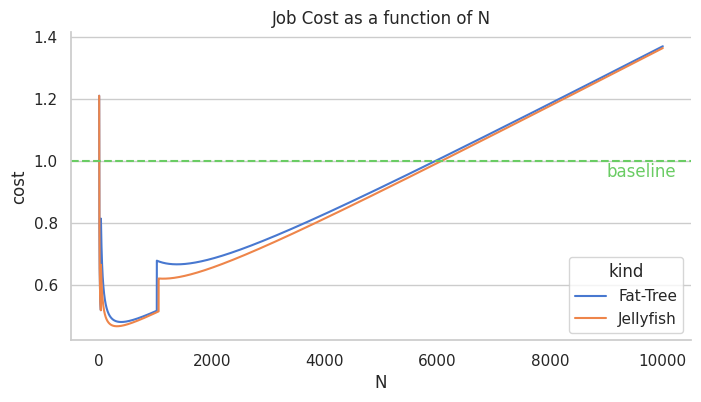

In [26]:
ax = sns.lineplot(
    trials, 
    x = 'N', 
    y = 'S_scaled',
    hue='kind',
    palette='muted'
)
ax.set(
    title = 'Job Cost as a function of N',
    ylabel = 'cost'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (9000, .95), color = baseline_color)

plt.gca().xaxis.grid(False)

## 2.4 Analysis
Let $n$ denote the number of ports in a router and $k = n/2$.


### Spikes
We note that there are some spikes in the graph, specifically the first is at 31. This is because any node has $k - 1 = 31$ immediate neighbours (at 2 hops of distance):

```
        [ ]
        /|\
      a1...ak
```

After the 31 most immediate neighbours we need to contact further away nodes and as such the RTT increments greatly. Let $h_{max}(n)$ denote the maximum number of hops we need to perform to contact at least n different nodes, then:
-  $h_{max}(32) = 3$ for Jellyfish topology.
-  $h_{max}(32) = 4$ for Fat-Tree topology

In fact the next spikes are when the topology requires us to increase $h_{max}$ again, which is at $k^2 + k - 1$ for the _Jellyfish_ and $k^2 - 1$ for the _Fat-Tree_.

The fact that the _Jellyfish_ topology is better then _Fat-Tree_ in terms of $h_{max}(\cdot)$ is not a surprise since the point of using a r-regular random graph is exactly to reduce the average shortest path length between two nodes.  

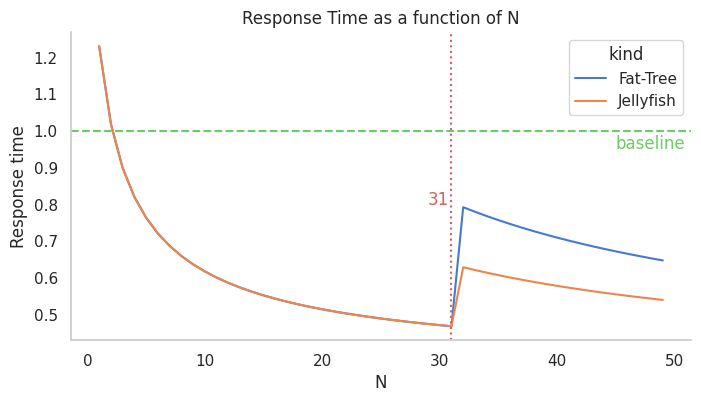

In [27]:
ax = sns.lineplot(
    trials[trials.N < 50], 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (45, .95), color = baseline_color)

red_muted = sns.color_palette('muted')[3]
plt.annotate('31', xy = (29, .8), color = red_muted)
plt.axvline(x=31, color=red_muted, linestyle = ':')

plt.grid(False)

Text(1056, 0.8, 'k^2+k-1')

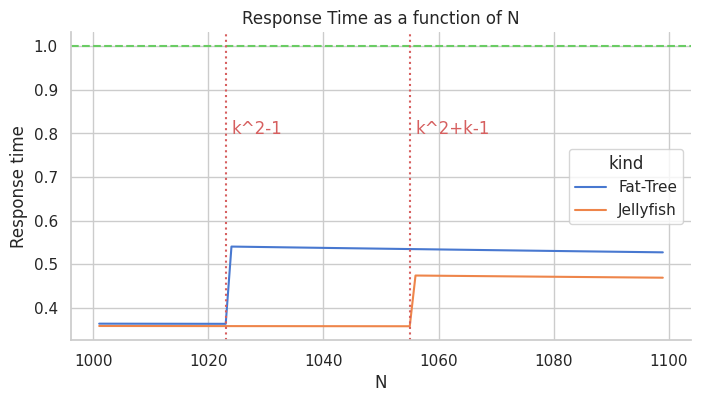

In [28]:
ax = sns.lineplot(
    trials[(1000 < trials.N) & (trials.N < 1100)], 
    x = 'N', 
    y = 'R_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Response Time as a function of N',
    ylabel = 'Response time'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (45, .95), color = baseline_color)

red_muted = sns.color_palette('muted')[3]
plt.axvline(x=k**2-1, color=red_muted, linestyle = ':')
plt.annotate('k^2-1', xy = (k**2, .8), color = red_muted)
plt.axvline(x=k-1+k**2, color=red_muted, linestyle = ':')
plt.annotate('k^2+k-1', xy = (k+k**2, .8), color = red_muted)

### Best cost

As expected from the spikes and since the term $E[\Theta]$ is linear in $n$ the best cost is reached early on: at $N=31$ we find the best cost both for _Jellyfish_ and _Fat-Tree_. 

This is expected due to the spikes in $R$ that we previously analyzed.

In [29]:
best_cost = trials.S.min()

best_cost_N = trials[trials.S == best_cost].N.iloc[0]
trials[trials.S == best_cost]

,kind,N,R,R_scaled,Theta,S,S_scaled
10316,Jellyfish,317,11005.224948,0.381728,38310,14836.224948,0.467828


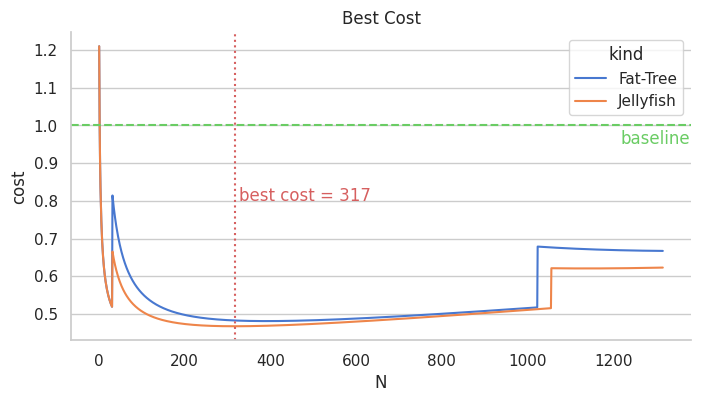

In [30]:
ax = sns.lineplot(
    trials[(trials.N < best_cost_N +1000) & (trials.N > best_cost_N -1000)], 
    x = 'N', 
    y = 'S_scaled',
    hue = 'kind'
)
ax.set(
    title = 'Best Cost',
    ylabel = 'cost'
)
plt.axhline(y=1, color=baseline_color, linestyle = '--')
plt.annotate('baseline', xy = (best_cost_N + 900, .95), color = baseline_color)

plt.annotate(f'best cost = {best_cost_N}', xy = (best_cost_N+10, .8), color = red_muted, size = 12)
plt.axvline(x=best_cost_N, color=red_muted, linestyle = ':')
plt.gca().xaxis.grid(False)

### Best time
The best time is obtained by the _Jellyfish_ topology right before the 2-nd spike of $R$.

In [31]:
best_time = trials.R.min()

trials[trials.R == best_time]

,kind,N,R,R_scaled,Theta,S,S_scaled
11054,Jellyfish,1055,10310.732187,0.357639,60450,16355.732187,0.515742


### Overall considerations
Overall the _Jellyfish_ topology performs better and cheaper than the _Fat-Tree_.


In [32]:
a = trials[trials.kind == 'Jellyfish'].set_index('N').join(trials[trials.kind == 'Fat-Tree'].set_index('N'), rsuffix='FT')

a[a.R > a.RFT]

,kind,R,R_scaled,Theta,S,S_scaled,kindFT,RFT,R_scaledFT,ThetaFT,SFT,S_scaledFT
N,,,,,,,,,,,,


### Hops number


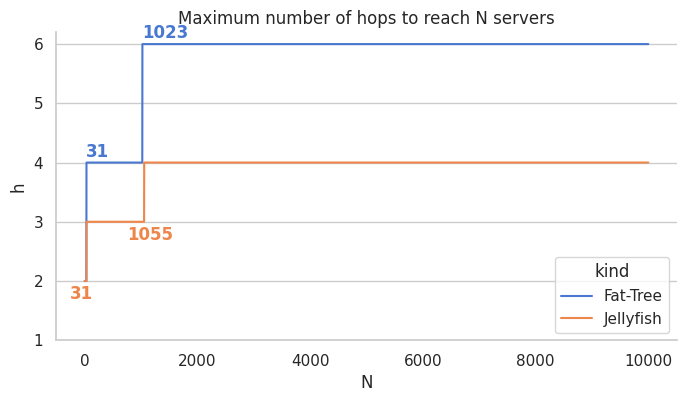

In [34]:
rrg_servers = Counter(n_closest(rrg, N, -1, leaves(rrg)).values())
ft_servers  = Counter(n_closest(ft, N, next(iter(leaves(ft))), leaves(ft)).values())

n_values = np.arange(1,10001)
h_rrg = np.array([max(count_closest(rrg_servers, n).keys()) for n in n_values ])
h_ft  = np.array([max(count_closest(ft_servers,  n).keys()) for n in n_values ])

h = pd.concat([
    pd.DataFrame({'N' : n_values, 'h': h_ft}),
    pd.DataFrame({'N' : n_values, 'h': h_rrg}),
    ], 
    keys=['Fat-Tree', 'Jellyfish'],
    names=['kind', 'id'])

h = h.reset_index('kind').reset_index(drop=True)

sns.lineplot(
    data = h,
    x = 'N',
    y = 'h',
    hue = 'kind'
).set(
    title = 'Maximum number of hops to reach N servers',
    yticks = list(range(1,7))
)



increases = lambda g: np.where(g[1:] - g[:-1])[0] + 1
for h in increases(h_rrg):
    plt.annotate(h, xy=(h - 300, h_rrg[h-1] -0.3), weight='bold', size=12, color = sns.color_palette('muted')[1])
for h in increases(h_ft):
    plt.annotate(h, xy=(h, h_ft[h] + 0.1), weight='bold', size=12, color = sns.color_palette('muted')[0])
plt.gca().xaxis.grid(False)